In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Fifa_dataset"
master = "yarn"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set("spark.jars", "gs://task4-data/postgresql-42.6.0.jar")\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

'''spark = SparkSession.builder.master("yarn").appName("task4").getOrCreate()'''

'''spark = SparkSession.builder.appName("task4").master("yarn").config("spark.jars", "gs://task4-data/postgresql-42.6.0.jar").getOrCreate()'''

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 08:37:57 INFO SparkEnv: Registering MapOutputTracker
23/11/16 08:37:57 INFO SparkEnv: Registering BlockManagerMaster
23/11/16 08:37:57 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/16 08:37:57 INFO SparkEnv: Registering OutputCommitCoordinator
/usr/lib/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


'spark = SparkSession.builder.appName("task4").master("yarn").config("spark.jars", "gs://task4-data/postgresql-42.6.0.jar").getOrCreate()'

In [5]:
from pyspark.sql.functions import lit
dfs = []
for year in range(15, 23):
    file_path = f'gs://task4-data/players_{year}.csv'
    df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .load(file_path)
    df = df.withColumn("year", lit(year))
    print(df.count())
    dfs.append(df)
    
df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.union(df)

print(df_final.count())

16155
15623
17596
17954
18085
18483
18944
19239


142079


In [6]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="SaiSravan@12"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://35.192.213.82:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "Fifa_Dataset"
#db_properties['Schemas'] = 'fifa'

df_final.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("driver", db_properties['driver'])\
.save()

23/11/16 08:40:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df_final = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_final.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 192479               
 player_url                  | https://sofifa.co... 
 short_name                  | B. Reeves            
 long_name                   | Benjamin Neil Reeves 
 player_positions            | CAM, CDM             
 overall                     | 60                   
 potential                   | 67                   
 value_eur                   | 210000.0             
 wage_eur                    | 2000.0               
 age                         | 22                   
 dob                         | 1991-11-19           
 height_cm                   | 171                  
 weight_kg                   | 67                   
 club_team_id                | 1798.0               
 club_name                   | Milton Keynes Dons   
 league_name                 | English League One   
 league_level                | 3                    
 club_position               | CAM            

In [8]:
df_after_drop = df_final.drop('sofifa_id', 'player_url', 'short_name', 'long_name', 'player_positions', 'dob', 'club_name', 'league_name',
                'wage_eur', 'club_jersey_number', 'club_loaned_from', 'club_joined', 'club_contract_valid_until', 'nationality_name',
                'nation_team_id', 'nation_position', 'nation_jersey_number', 'work_rate', 'body_type', 'real_face', 'release_clause',
                'player_tags', 'player_traits', 'mentality_composure', 'goalkeeping_speed', 'player_face_url', 'club_logo_url',
                             'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'release_clause_eur', 'year')

df_after_drop.show(1, vertical=True)

-RECORD 0-------------------------------
 overall                     | 60       
 potential                   | 67       
 value_eur                   | 210000.0 
 age                         | 22       
 height_cm                   | 171      
 weight_kg                   | 67       
 club_team_id                | 1798.0   
 league_level                | 3        
 club_position               | CAM      
 nationality_id              | 35       
 preferred_foot              | Left     
 weak_foot                   | 3        
 skill_moves                 | 2        
 international_reputation    | 1        
 pace                        | 73       
 shooting                    | 57       
 passing                     | 56       
 dribbling                   | 65       
 defending                   | 53       
 physic                      | 63       
 attacking_crossing          | 59       
 attacking_finishing         | 62       
 attacking_heading_accuracy  | 43       
 attacking_short

In [9]:
from pyspark.sql.functions import *

null_counts_df = df_after_drop.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_after_drop.columns])
null_counts_df.show(truncate=False, vertical=True)

-RECORD 0----------------------------
 overall                     | 0     
 potential                   | 0     
 value_eur                   | 1897  
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 club_team_id                | 1630  
 league_level                | 2015  
 club_position               | 1630  
 nationality_id              | 0     
 preferred_foot              | 0     
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 pace                        | 15791 
 shooting                    | 15791 
 passing                     | 15791 
 dribbling                   | 15791 
 defending                   | 15791 
 physic                      | 15791 
 attacking_crossing          | 0     
 attacking_finishing         | 0     
 attacking_heading_accuracy  | 0     
 attacking_short_passing     | 0     
 attacking_volleys           | 0     
 skill_dribb

In [10]:
#dropping rows shown below and check again for the number of null values
columns_to_check = ["pace", "shooting", "passing", "dribbling", "defending", "physic", "club_team_id", "league_level"]
df_with_na_dropped_rows = df_after_drop.na.drop(subset = columns_to_check)

null_counts_df_after_rows_dropped = df_with_na_dropped_rows.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_with_na_dropped_rows.columns])
null_counts_df_after_rows_dropped.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 value_eur                   | 275 
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 club_position               | 0   
 nationality_id              | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                

In [11]:
df_with_na_dropped_rows.printSchema()

root
 |-- overall: string (nullable = true)
 |-- potential: string (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- age: string (nullable = true)
 |-- height_cm: string (nullable = true)
 |-- weight_kg: string (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- nationality_id: string (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: string (nullable = true)
 |-- skill_moves: string (nullable = true)
 |-- international_reputation: string (nullable = true)
 |-- pace: string (nullable = true)
 |-- shooting: string (nullable = true)
 |-- passing: string (nullable = true)
 |-- dribbling: string (nullable = true)
 |-- defending: string (nullable = true)
 |-- physic: string (nullable = true)
 |-- attacking_crossing: string (nullable = true)
 |-- attacking_finishing: string (nullable = true)
 |-- attacking_heading_accuracy: string (nullable = true

In [12]:
df_with_na_dropped_rows = df_with_na_dropped_rows.withColumn('value_eur', col('value_eur').cast("double"))

In [13]:
from pyspark.ml.feature import Imputer

columns_to_be_imputed = ["value_eur"]
value_not_in_dataset = 0

# Replace None/Missing Value with a value that can't be present in the dataset.
df_without_imputation = df_with_na_dropped_rows.fillna(0, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_without_imputation).transform(df_without_imputation)
# we will drop the old column without imputation. We have only one column to be imputed
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])
# We will rename our newly imputed column with the correct name
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("value_eur_imputed","value_eur")

In [14]:
null_counts_df_after_rows_dropped = df_fully_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_fully_imputed.columns])
null_counts_df_after_rows_dropped.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 club_position               | 0   
 nationality_id              | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy          

In [15]:
df_fully_imputed.count()

124562

In [16]:
# Few values like "ls, st, rs lw, lf, cf, rf, rw, lam, cam, ram, lm, lcm, rcm, rm, lwb, ldm, \
#cdm, rdm, rwb, lb, lcb, cb, rcb, rb, gk" have ability + international reputation. As international reputation is already mentioned\
# We plan to remove international reputation and just keep the ability and store it as an integer.

columns_to_remove_plus = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]

for col_name in columns_to_remove_plus:
    df_fully_imputed = df_fully_imputed.withColumn(f"{col_name}_split", split(col(col_name), "\\+")[0])
    df_fully_imputed = df_fully_imputed.drop(col_name)
    df_fully_imputed = df_fully_imputed.withColumnRenamed(f"{col_name}_split", col_name)

In [17]:
# Summary 
df_fully_imputed.summary().show(truncate=False, vertical=True)

-RECORD 0-----------------------------------------
 summary                     | count              
 overall                     | 124562             
 potential                   | 124562             
 age                         | 124562             
 height_cm                   | 124562             
 weight_kg                   | 124562             
 club_team_id                | 124562             
 league_level                | 124562             
 club_position               | 124562             
 nationality_id              | 124562             
 preferred_foot              | 124562             
 weak_foot                   | 124562             
 skill_moves                 | 124562             
 international_reputation    | 124562             
 pace                        | 124562             
 shooting                    | 124562             
 passing                     | 124562             
 dribbling                   | 124562             
 defending                   | 

In [18]:
# get all the data types
df_fully_imputed.dtypes

[('overall', 'string'),
 ('potential', 'string'),
 ('age', 'string'),
 ('height_cm', 'string'),
 ('weight_kg', 'string'),
 ('club_team_id', 'string'),
 ('league_level', 'string'),
 ('club_position', 'string'),
 ('nationality_id', 'string'),
 ('preferred_foot', 'string'),
 ('weak_foot', 'string'),
 ('skill_moves', 'string'),
 ('international_reputation', 'string'),
 ('pace', 'string'),
 ('shooting', 'string'),
 ('passing', 'string'),
 ('dribbling', 'string'),
 ('defending', 'string'),
 ('physic', 'string'),
 ('attacking_crossing', 'string'),
 ('attacking_finishing', 'string'),
 ('attacking_heading_accuracy', 'string'),
 ('attacking_short_passing', 'string'),
 ('attacking_volleys', 'string'),
 ('skill_dribbling', 'string'),
 ('skill_curve', 'string'),
 ('skill_fk_accuracy', 'string'),
 ('skill_long_passing', 'string'),
 ('skill_ball_control', 'string'),
 ('movement_acceleration', 'string'),
 ('movement_sprint_speed', 'string'),
 ('movement_agility', 'string'),
 ('movement_reactions', 'st

In [19]:
from pyspark.sql.functions import col

columns_string = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm", 'value_eur']

cols = ['potential', 'age', 'height_cm', 'weight_kg', 'club_team_id',
    'league_level', 'nationality_id', 'weak_foot',
    'skill_moves', 'international_reputation', 'pace', 'shooting', 'passing',
    'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing',
    'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
    'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
    'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power',
    'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning',
    'mentality_vision', 'mentality_penalties', 'defending_marking_awareness',
    'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving',
    'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
    'goalkeeping_reflexes']

for col_name in cols:
    df_fully_imputed = df_fully_imputed.withColumn(col_name, col(col_name).cast("int"))    

In [20]:
df_fully_imputed = df_fully_imputed.withColumn('overall', col('overall').cast("int"))

In [21]:
df_fully_imputed.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_finishing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_shor

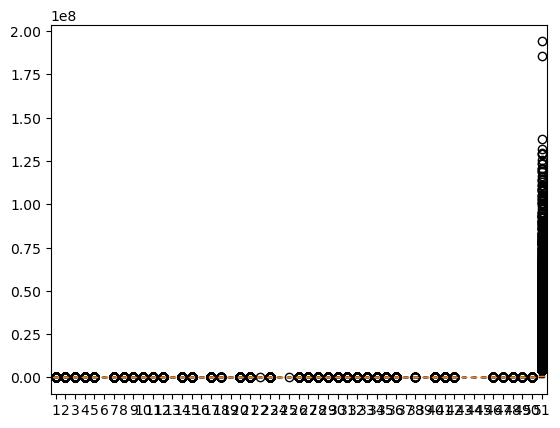

In [22]:
import matplotlib.pyplot as plt
numeric_features = [feature[0] for feature in df_fully_imputed.dtypes if feature[1] in ('int','double')]
#Extract data and convert them into Pandas for visualization
converted_data = df_fully_imputed[numeric_features].toPandas()
figure = plt.boxplot(converted_data)

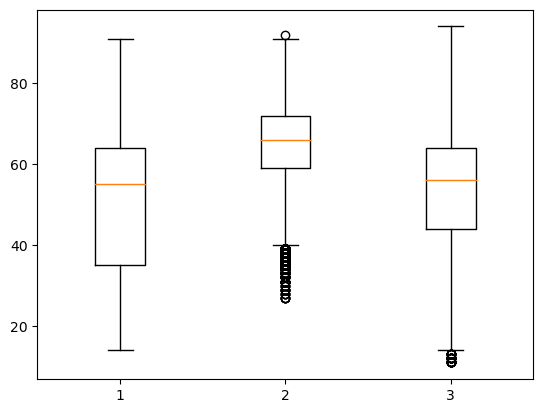

In [23]:
spotted_data = df_fully_imputed[numeric_features[15:18]].toPandas()
figure_subset = plt.boxplot(spotted_data)

In [24]:
figure_subset.keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

In [25]:
# Values printed as comma separated Q1, Q3 for each object.
[item.get_ydata()[1] for item in figure_subset['whiskers']]

[14.0, 91.0, 40.0, 91.0, 14.0, 94.0]

In [26]:
# how to print outliers?!
[item.get_ydata() for item in figure_subset['fliers']]

[array([], dtype=int32),
 array([36, 35, 33, ..., 38, 39, 92], dtype=int32),
 array([11, 12, 13, 12, 12, 13, 13, 12, 13, 11, 12, 12, 11, 11, 11, 13, 11,
        12, 11, 12, 12, 12, 11, 12, 13, 12, 11, 13, 12, 11, 11, 11, 12, 11,
        11, 11, 13, 11, 12, 12, 13, 11, 12, 12, 12, 12, 11, 13],
       dtype=int32)]

In [27]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [28]:
numeric_columns = [column[0] for column in df_fully_imputed.dtypes if column[1] in ('int','double')]
df_fully_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_columns]).show(1, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 nationality_id              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control         

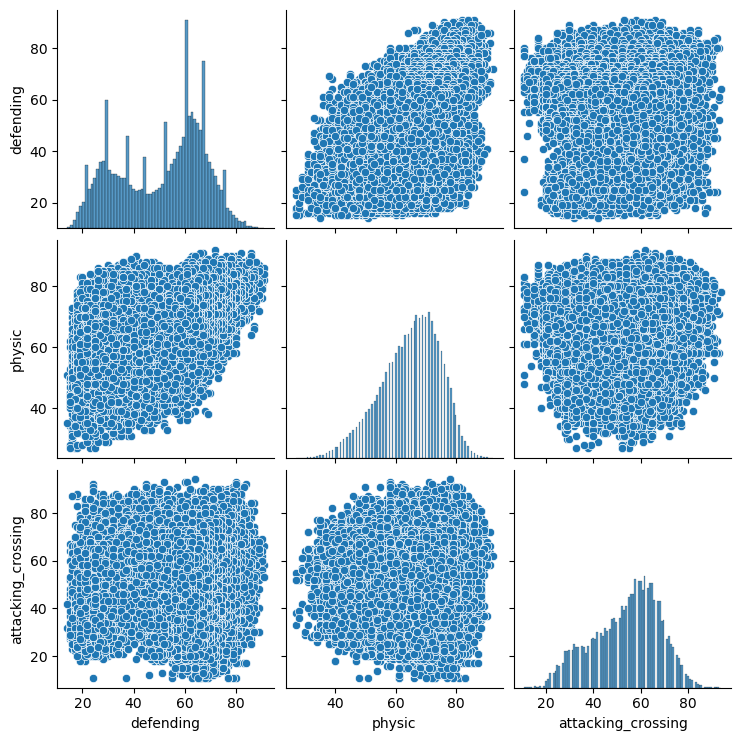

In [29]:
import seaborn as sb
sb.pairplot(spotted_data)

In [30]:
correlation_matrix = df_fully_imputed.toPandas().corr()
print(correlation_matrix)

                              overall  potential       age  height_cm  \
overall                      1.000000   0.692426  0.458722   0.068262   
potential                    0.692426   1.000000 -0.208002   0.025373   
age                          0.458722  -0.208002  1.000000   0.066461   
height_cm                    0.068262   0.025373  0.066461   1.000000   
weight_kg                    0.163092   0.009470  0.211422   0.747324   
club_team_id                -0.173239  -0.259153  0.086155  -0.120186   
league_level                -0.231041  -0.201822 -0.055791   0.066584   
nationality_id              -0.079357  -0.150573  0.058506  -0.139162   
weak_foot                    0.218669   0.156165  0.107816  -0.098477   
skill_moves                  0.391366   0.323694  0.099830  -0.275065   
international_reputation     0.492937   0.370354  0.259211   0.046251   
pace                         0.188422   0.265912 -0.200288  -0.411352   
shooting                     0.483123   0.320738  0

In [31]:
import numpy as np

# checking which has a value more than 0.9 to remove redundant features
threshold = 0.9
high_correlation_points = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1,correlation_matrix.shape[0]):
        if np.abs(correlation_matrix.iloc[i,j])>threshold:
            
            high_correlation_points.append([correlation_matrix.columns[i], correlation_matrix.columns[j]])
for points in high_correlation_points:
    print(points)

['pace', 'movement_acceleration']
['pace', 'movement_sprint_speed']
['shooting', 'attacking_finishing']
['shooting', 'power_long_shots']
['passing', 'attacking_short_passing']
['dribbling', 'skill_dribbling']
['dribbling', 'skill_ball_control']
['defending', 'mentality_interceptions']
['defending', 'defending_marking_awareness']
['defending', 'defending_standing_tackle']
['defending', 'defending_sliding_tackle']
['mentality_interceptions', 'defending_standing_tackle']
['mentality_interceptions', 'defending_sliding_tackle']
['defending_marking_awareness', 'defending_standing_tackle']
['defending_marking_awareness', 'defending_sliding_tackle']
['defending_standing_tackle', 'defending_sliding_tackle']


In [32]:
df_after_corr = df_fully_imputed.drop('movement_acceleration', 'movement_sprint_speed', 'attacking_finishing',
                                     'power_long_shots', 'attacking_short_passing', 'skill_dribbling', 'skill_ball_control',
                                     'mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle',
                                     'defending_sliding_tackle')
df_after_corr.show(vertical = True)

-RECORD 0------------------------------
 overall                    | 60       
 potential                  | 67       
 age                        | 22       
 height_cm                  | 171      
 weight_kg                  | 67       
 club_team_id               | 1798     
 league_level               | 3        
 club_position              | CAM      
 nationality_id             | 35       
 preferred_foot             | Left     
 weak_foot                  | 3        
 skill_moves                | 2        
 international_reputation   | 1        
 pace                       | 73       
 shooting                   | 57       
 passing                    | 56       
 dribbling                  | 65       
 defending                  | 53       
 physic                     | 63       
 attacking_crossing         | 59       
 attacking_heading_accuracy | 43       
 attacking_volleys          | 40       
 skill_curve                | 25       
 skill_fk_accuracy          | 43       


In [33]:
#handling binary variables. Like preferred foot... Left =1; Right =0
df_after_corr = df_after_corr.withColumn("preferred_foot", when(col("preferred_foot") == "Left", 1).otherwise(0))

#the last few columns like columns_to_remove_plus = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", 
#"cam", "ram", "lm", "lcm", "rcm", "rm", "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]
# are strings typecast into integers.
columns_to_cast = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]
for col_name in columns_to_cast:
    df_after_corr = df_after_corr.withColumn(col_name, col(col_name).cast("int"))
df_after_corr.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: integer (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- preferred_foot: integer (nullable = false)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_curve: i

In [34]:
from pyspark.sql.functions import col, sum

# Assuming df is your DataFrame
# Check for missing values in each column
missing_values = df_after_corr.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_after_corr.columns])

# Show the results
missing_values.show(vertical=True)

-RECORD 0--------------------------
 overall                    | 0    
 potential                  | 0    
 age                        | 0    
 height_cm                  | 0    
 weight_kg                  | 0    
 club_team_id               | 0    
 league_level               | 0    
 club_position              | 0    
 nationality_id             | 0    
 preferred_foot             | 0    
 weak_foot                  | 0    
 skill_moves                | 0    
 international_reputation   | 0    
 pace                       | 0    
 shooting                   | 0    
 passing                    | 0    
 dribbling                  | 0    
 defending                  | 0    
 physic                     | 0    
 attacking_crossing         | 0    
 attacking_heading_accuracy | 0    
 attacking_volleys          | 0    
 skill_curve                | 0    
 skill_fk_accuracy          | 0    
 skill_long_passing         | 0    
 movement_agility           | 0    
 movement_reactions         

In [35]:
columns_to_check = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]
df_after_corr = df_after_corr.na.drop(subset = columns_to_check)
df_after_corr.show(1, vertical=True)

-RECORD 0------------------------------
 overall                    | 60       
 potential                  | 67       
 age                        | 22       
 height_cm                  | 171      
 weight_kg                  | 67       
 club_team_id               | 1798     
 league_level               | 3        
 club_position              | CAM      
 nationality_id             | 35       
 preferred_foot             | 1        
 weak_foot                  | 3        
 skill_moves                | 2        
 international_reputation   | 1        
 pace                       | 73       
 shooting                   | 57       
 passing                    | 56       
 dribbling                  | 65       
 defending                  | 53       
 physic                     | 63       
 attacking_crossing         | 59       
 attacking_heading_accuracy | 43       
 attacking_volleys          | 40       
 skill_curve                | 25       
 skill_fk_accuracy          | 43       


In [36]:
from pyspark.sql.functions import col, sum

# Assuming df is your DataFrame
# Check for missing values in each column
missing_values = df_after_corr.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_after_corr.columns])

# Show the results
missing_values.show(vertical=True)

-RECORD 0-------------------------
 overall                    | 0   
 potential                  | 0   
 age                        | 0   
 height_cm                  | 0   
 weight_kg                  | 0   
 club_team_id               | 0   
 league_level               | 0   
 club_position              | 0   
 nationality_id             | 0   
 preferred_foot             | 0   
 weak_foot                  | 0   
 skill_moves                | 0   
 international_reputation   | 0   
 pace                       | 0   
 shooting                   | 0   
 passing                    | 0   
 dribbling                  | 0   
 defending                  | 0   
 physic                     | 0   
 attacking_crossing         | 0   
 attacking_heading_accuracy | 0   
 attacking_volleys          | 0   
 skill_curve                | 0   
 skill_fk_accuracy          | 0   
 skill_long_passing         | 0   
 movement_agility           | 0   
 movement_reactions         | 0   
 movement_balance   

In [37]:
df_with_handled_binary = df_after_corr
#We handled the binary values in the above cell

In [38]:
#do string indexing for club_positions

from pyspark.ml import Transformer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stage_1 = StringIndexer(inputCol= 'club_position', outputCol= 'club_position_index')
#stage_2= OneHotEncoder(inputCols=['club_position_index'], outputCols=['club_position_encoded'])

pipeline = Pipeline(stages = [stage_1])
pipeline_model = pipeline.fit(df_with_handled_binary)
df_encoded = pipeline_model.transform(df_with_handled_binary)

In [39]:
#check if one hot encoding is properly done and view output

print(df_encoded.select("club_position").distinct().count())
df_encoded.select("club_position","club_position_index")\
                .distinct().toPandas()

28


,club_position,club_position_index
0,LW,16.0
1,LWB,22.0
2,RM,8.0
3,RS,15.0
4,ST,6.0
5,CB,19.0
6,LS,14.0
7,RW,17.0
8,LCB,3.0
9,LF,25.0


In [40]:
feature_list = df_encoded.drop('club_position', 'overall')
feature_list.show(1, vertical=True)

-RECORD 0------------------------------
 potential                  | 67       
 age                        | 22       
 height_cm                  | 171      
 weight_kg                  | 67       
 club_team_id               | 1798     
 league_level               | 3        
 nationality_id             | 35       
 preferred_foot             | 1        
 weak_foot                  | 3        
 skill_moves                | 2        
 international_reputation   | 1        
 pace                       | 73       
 shooting                   | 57       
 passing                    | 56       
 dribbling                  | 65       
 defending                  | 53       
 physic                     | 63       
 attacking_crossing         | 59       
 attacking_heading_accuracy | 43       
 attacking_volleys          | 40       
 skill_curve                | 25       
 skill_fk_accuracy          | 43       
 skill_long_passing         | 53       
 movement_agility           | 82       


In [41]:
print(feature_list.columns)

['potential', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'league_level', 'nationality_id', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_heading_accuracy', 'attacking_volleys', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'value_eur', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'cm', 'club_position_index']


In [42]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(
    inputCols=feature_list.columns, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

In [43]:
df_with_assembled_features.select("vectorized_features").show(1, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|vectorized_features                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
df_with_assembled_features.show(3, vertical=True)

-RECORD 0------------------------------------------
 overall                    | 60                   
 potential                  | 67                   
 age                        | 22                   
 height_cm                  | 171                  
 weight_kg                  | 67                   
 club_team_id               | 1798                 
 league_level               | 3                    
 club_position              | CAM                  
 nationality_id             | 35                   
 preferred_foot             | 1                    
 weak_foot                  | 3                    
 skill_moves                | 2                    
 international_reputation   | 1                    
 pace                       | 73                   
 shooting                   | 57                   
 passing                    | 56                   
 dribbling                  | 65                   
 defending                  | 53                   
 physic     

In [45]:
cols_to_keep = ['vectorized_features', 'overall']
features_list = df_with_assembled_features.select(*cols_to_keep)

In [46]:
features_list.show(vertical=True)

-RECORD 0-----------------------------------
 vectorized_features | [67.0,22.0,171.0,... 
 overall             | 60                   
-RECORD 1-----------------------------------
 vectorized_features | [66.0,25.0,185.0,... 
 overall             | 60                   
-RECORD 2-----------------------------------
 vectorized_features | [66.0,25.0,180.0,... 
 overall             | 60                   
-RECORD 3-----------------------------------
 vectorized_features | [64.0,25.0,184.0,... 
 overall             | 60                   
-RECORD 4-----------------------------------
 vectorized_features | [67.0,22.0,190.0,... 
 overall             | 60                   
-RECORD 5-----------------------------------
 vectorized_features | [64.0,26.0,190.0,... 
 overall             | 60                   
-RECORD 6-----------------------------------
 vectorized_features | [68.0,22.0,181.0,... 
 overall             | 60                   
-RECORD 7-----------------------------------
 vectorize

In [47]:
split = features_list.randomSplit([0.7, 0.3])
df_train = split[0]
df_test = split[1]

## Model - 1 - Linear Regression - SparkML

In [48]:
from pyspark.ml.regression import LinearRegression

lr_hyper1 = LinearRegression(featuresCol = 'vectorized_features', labelCol='overall',
                      maxIter=20, regParam=0.5, elasticNetParam=0.2)
lr_hyper1_model = lr_hyper1.fit(df_train)
trainingSummary = lr_hyper1_model.summary
print("Training MSE hyper1: %f" % trainingSummary.meanSquaredError)
print("Training r2 hyper1: %f" % trainingSummary.r2)
test_result = lr_hyper1_model.evaluate(df_test)
print("Test MSE hyper1:", test_result.meanSquaredError)
print("Training r2 hyper1: %f" % test_result.r2)

Training MSE hyper1: 3.739416
Training r2 hyper1: 0.924361


Test MSE hyper1: 3.7217824888329623
Training r2 hyper1: 0.925079


In [49]:
def plot_r2(gt, pred, title):
    plt.figure(figsize=[5,5])

    plt.scatter(gt, pred, marker= ".")
    plt.plot([-1000,1000], [-1000,1000],"r--")

    all = np.concatenate([gt, pred])
    plt.xlim(np.min(all), np.max(all))
    plt.ylim(np.min(all), np.max(all))
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    plt.show()

In [50]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import numpy as np
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_x_test_pandas = df_test.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array = np.array(df_x_test_pandas['overall'].values.tolist(), dtype=np.float32)

In [51]:
lr_predictions = lr_hyper1_model.transform(df_test)
lr_predictions.show(2, vertical=True)

-RECORD 0-----------------------------------
 vectorized_features | [46.0,28.0,173.0,... 
 overall             | 46                   
 prediction          | 47.02566387601823    
-RECORD 1-----------------------------------
 vectorized_features | [47.0,32.0,176.0,... 
 overall             | 47                   
 prediction          | 48.93976703463131    
only showing top 2 rows



In [52]:
df_x_test_pred_pandas = lr_predictions.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array_pred = np.array(df_x_test_pred_pandas['prediction'].values.tolist(), dtype=np.float32)

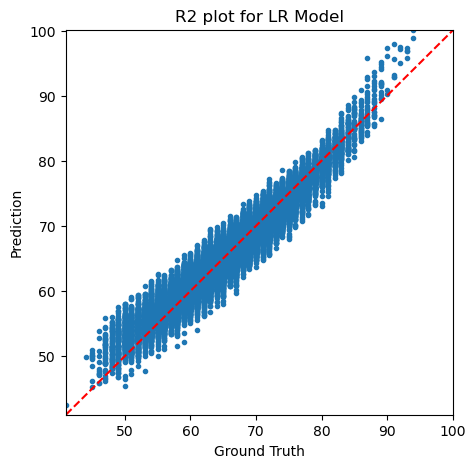

In [53]:
plot_r2(overall_array, overall_array_pred, 'R2 plot for LR Model')

## Model - 2 - Gradient Boosted Regression

In [54]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

gbt_param3 = GBTRegressor(featuresCol = 'vectorized_features', labelCol = 'overall', maxDepth = 10, maxIter=20, stepSize = 0.1)
gbt_param3_model = gbt_param3.fit(df_train)

gbt_predictions_train = gbt_param3_model.transform(df_train)
gbt_evaluator_mse = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_train = gbt_evaluator_mse.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse_train)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_train = gbt_evaluator_r2.evaluate(gbt_predictions_train)
print("R2 on train data = %g" % r2_train)

#testing_data_hyperparam3
gbt_predictions_test = gbt_param3_model.transform(df_test)
gbt_evaluator = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_test = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse_test)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_test = gbt_evaluator_r2.evaluate(gbt_predictions_test)
print("R2 on test data = %g" % r2_test)

23/11/16 08:49:31 WARN YarnAllocator: Container from a bad node: container_1700115469683_0005_01_000002 on host: cluster-a960-m.us-central1-f.c.test1-397615.internal. Exit status: 137. Diagnostics: [2023-11-16 08:49:30.781]Container killed on request. Exit code is 137
[2023-11-16 08:49:30.781]Container exited with a non-zero exit code 137. 
[2023-11-16 08:49:30.781]Killed by external signal
.
23/11/16 08:49:31 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container from a bad node: container_1700115469683_0005_01_000002 on host: cluster-a960-m.us-central1-f.c.test1-397615.internal. Exit status: 137. Diagnostics: [2023-11-16 08:49:30.781]Container killed on request. Exit code is 137
[2023-11-16 08:49:30.781]Container exited with a non-zero exit code 137. 
[2023-11-16 08:49:30.781]Killed by external signal
.
23/11/16 08:49:31 ERROR YarnScheduler: Lost executor 2 on cluster-a960-m.us-central1-f.c.test1-397615.internal: Container from a 

Mean Squared Error (MSE) on train data = 0.357723


R2 on train data = 0.992764


Mean Squared Error (MSE) on test data = 0.640729


23/11/16 08:51:26 WARN YarnAllocator: Container from a bad node: container_1700115469683_0005_01_000005 on host: cluster-a960-m.us-central1-f.c.test1-397615.internal. Exit status: 137. Diagnostics: [2023-11-16 08:51:25.958]Container killed on request. Exit code is 137
[2023-11-16 08:51:25.958]Container exited with a non-zero exit code 137. 
[2023-11-16 08:51:25.959]Killed by external signal
.
23/11/16 08:51:26 ERROR YarnScheduler: Lost executor 4 on cluster-a960-m.us-central1-f.c.test1-397615.internal: Container from a bad node: container_1700115469683_0005_01_000005 on host: cluster-a960-m.us-central1-f.c.test1-397615.internal. Exit status: 137. Diagnostics: [2023-11-16 08:51:25.958]Container killed on request. Exit code is 137
[2023-11-16 08:51:25.958]Container exited with a non-zero exit code 137. 
[2023-11-16 08:51:25.959]Killed by external signal
.
23/11/16 08:51:26 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 4 for reason Container from a 

R2 on test data = 0.987102


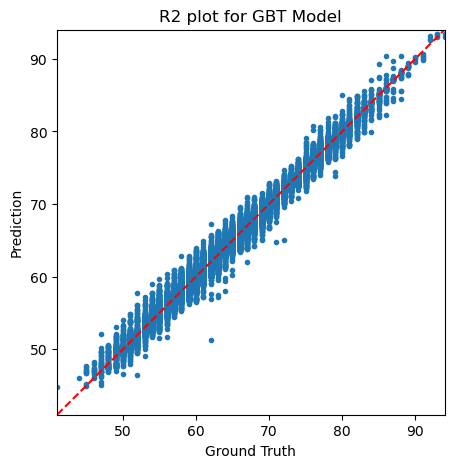

In [55]:
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_x_test_pandas = df_test.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array = np.array(df_x_test_pandas['overall'].values.tolist(), dtype=np.float32)

df_x_test_pred_pandas = gbt_predictions_test.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array_pred = np.array(df_x_test_pred_pandas['prediction'].values.tolist(), dtype=np.float32)

plot_r2(overall_array, overall_array_pred, 'R2 plot for GBT Model')

## Model - 3 - Pytorch - Shallow Network

In [56]:
!pip install torch

In [57]:
import torch
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import numpy as np

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_x_train_pandas = features_list.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
vectorized_features_array = np.array(df_x_train_pandas['vectorized_features'].values.tolist(), dtype=np.float32)
df_x_train = torch.from_numpy(vectorized_features_array)
overall_array = np.array(df_x_train_pandas['overall'].values.tolist(), dtype=np.float32)
df_y_train =  torch.from_numpy(overall_array)

In [58]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x)  # Assuming x is a NumPy array or a list
        self.y = torch.tensor(y)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset_train = MyDataset(df_x_train, df_y_train)
train_dataset_len = len(dataset_train)
test_dataset_len = int(train_dataset_len*0.3)
train_dataset_len = train_dataset_len - test_dataset_len
train_dataset,test_dataset = torch.utils.data.random_split(dataset_train, [train_dataset_len, test_dataset_len])

/tmp/ipykernel_38831/2843416515.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x)  # Assuming x is a NumPy array or a list
/tmp/ipykernel_38831/2843416515.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


In [59]:
test_dataset_len = len(test_dataset)
validate_dataset_len = int(test_dataset_len*0.5)
test_dataset_len = test_dataset_len - validate_dataset_len
test_dataset,validate_dataset = torch.utils.data.random_split(test_dataset, [test_dataset_len, validate_dataset_len])

In [60]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
                        nn.Linear(in_features = vectorized_features_array.shape[1], out_features = 15),
                        nn.ReLU(),
                        nn.Linear(in_features = 15, out_features = 1),
                        )
    def forward(self, x):
        return self.layer_stack(x)

In [61]:
model1 = NeuralNetwork()
print(model1)

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Linear(in_features=68, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)


In [62]:
from torch import optim
model1 = NeuralNetwork()
#hyper parameters iteration 1
lr = 0.05
batch_size = 256
N_epochs = 50
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
        
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

/opt/conda/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([197])) that is different to the input size (torch.Size([197, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/miniconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([188])) that is different to the input size (torch.Size([188, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Epoch = 0, train_loss = 1975492224.0, validate_loss = 4372.5283203125
Best epoch
Epoch = 1, train_loss = 4367.00390625, validate_loss = 4361.4892578125
Best epoch
Epoch = 2, train_loss = 4352.8876953125, validate_loss = 4344.75048828125
Best epoch
Epoch = 3, train_loss = 4333.9345703125, validate_loss = 4323.74951171875
Best epoch
Epoch = 4, train_loss = 4310.06103515625, validate_loss = 4296.8369140625
Best epoch
Epoch = 5, train_loss = 4280.80078125, validate_loss = 4264.33447265625
Best epoch
Epoch = 6, train_loss = 4245.5966796875, validate_loss = 4226.20849609375
Best epoch
Epoch = 7, train_loss = 4203.64111328125, validate_loss = 4180.44921875
Best epoch


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 37204)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.r

Epoch = 8, train_loss = 4154.06298828125, validate_loss = 4127.087890625
Best epoch
Epoch = 9, train_loss = 4096.06591796875, validate_loss = 4064.427490234375
Best epoch
Epoch = 10, train_loss = 4028.44189453125, validate_loss = 3991.18017578125
Best epoch
Epoch = 11, train_loss = 3949.98291015625, validate_loss = 3906.64990234375
Best epoch
Epoch = 12, train_loss = 3859.56298828125, validate_loss = 3810.2421875
Best epoch
Epoch = 13, train_loss = 3755.851318359375, validate_loss = 3699.625
Best epoch
Epoch = 14, train_loss = 3637.412841796875, validate_loss = 3572.634521484375
Best epoch
Epoch = 15, train_loss = 3503.01318359375, validate_loss = 3430.255859375
Best epoch
Epoch = 16, train_loss = 3351.712646484375, validate_loss = 3270.228759765625
Best epoch
Epoch = 17, train_loss = 3182.43408203125, validate_loss = 3091.846435546875
Best epoch
Epoch = 18, train_loss = 2994.93701171875, validate_loss = 2894.846435546875
Best epoch
Epoch = 19, train_loss = 2789.43310546875, validate_l

(0.0, 1000.0)

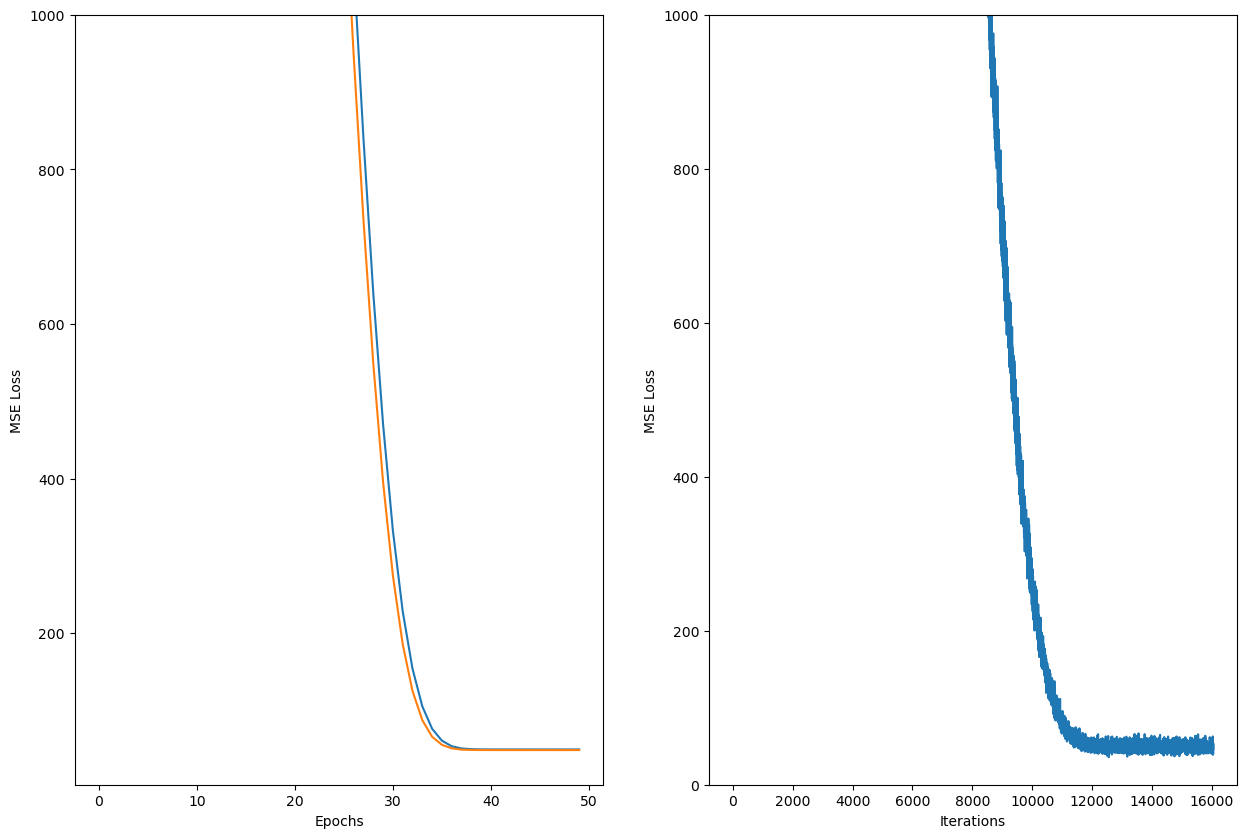

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
axes[0].plot(range(N_epochs), losses, label='Train Loss')
axes[0].plot(range(N_epochs), validate_losses, label = 'Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")
axes[0].set_ylim(4, 1000)

axes[1].plot(range(len(batch_loss_graph)), np.array(batch_loss_graph).squeeze(), label = 'Losses for each iteration')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE Loss")
axes[1].set_ylim(0, 1000)

In [64]:
mybestmodel  = NeuralNetwork()
test_batch_loss = []
lossfun = nn.MSELoss()
mybestmodel.load_state_dict(torch.load("current_best_model"))
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    loss = lossfun(prediction_score, y_batch) 
    test_batch_loss.append(loss.detach().numpy())
final_loss = (np.mean(np.array(test_batch_loss)))
print(f"Test MSE loss = {final_loss}")

Test MSE loss = 49.5721435546875


## Model - 4 - Pytorch - Deep Network

In [65]:
from torch import nn
class NeuralNetwork_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
                        nn.Linear(in_features = vectorized_features_array.shape[1], out_features = 128),
                        nn.ReLU(),
                        nn.Linear(in_features = 128, out_features = 256),
                        nn.ReLU(),
                        nn.Linear(in_features = 256, out_features = 256),
                        nn.ReLU(),
                        nn.Linear(in_features = 256, out_features = 128),
                        nn.ReLU(),
                        nn.Linear(in_features = 128, out_features = 64),
                        nn.ReLU(),
                        nn.Linear(in_features = 64, out_features = 32),
                        nn.ReLU(),
                        nn.Linear(in_features = 32, out_features = 1),
                        )
    def forward(self, x):
        return self.layer_stack(x)

In [66]:
model1 = NeuralNetwork_deep()
print(model1)

NeuralNetwork_deep(
  (layer_stack): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [67]:
from torch import optim
#hyper parameters iteration 4
lr = 0.01
batch_size = 256
N_epochs = 15
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

Epoch = 0, train_loss = 62004056.0, validate_loss = 2220.52001953125
Best epoch
Epoch = 1, train_loss = 7230.6259765625, validate_loss = 88.56416320800781
Best epoch
Epoch = 2, train_loss = 68.71717834472656, validate_loss = 59.39065933227539
Best epoch
Epoch = 3, train_loss = 60.95507049560547, validate_loss = 55.36078643798828
Best epoch
Epoch = 4, train_loss = 3901.7822265625, validate_loss = 1225.7965087890625
Epoch = 5, train_loss = 446.7886962890625, validate_loss = 48.83644485473633
Best epoch
Epoch = 6, train_loss = 49.645381927490234, validate_loss = 48.86482620239258
Epoch = 7, train_loss = 49.644615173339844, validate_loss = 48.85688400268555
Epoch = 8, train_loss = 49.64265823364258, validate_loss = 48.80585479736328
Best epoch
Epoch = 9, train_loss = 49.64436721801758, validate_loss = 48.86072540283203
Epoch = 10, train_loss = 49.64249801635742, validate_loss = 48.83498764038086
Epoch = 11, train_loss = 49.64487838745117, validate_loss = 48.82716369628906
Epoch = 12, train

(30.0, 600.0)

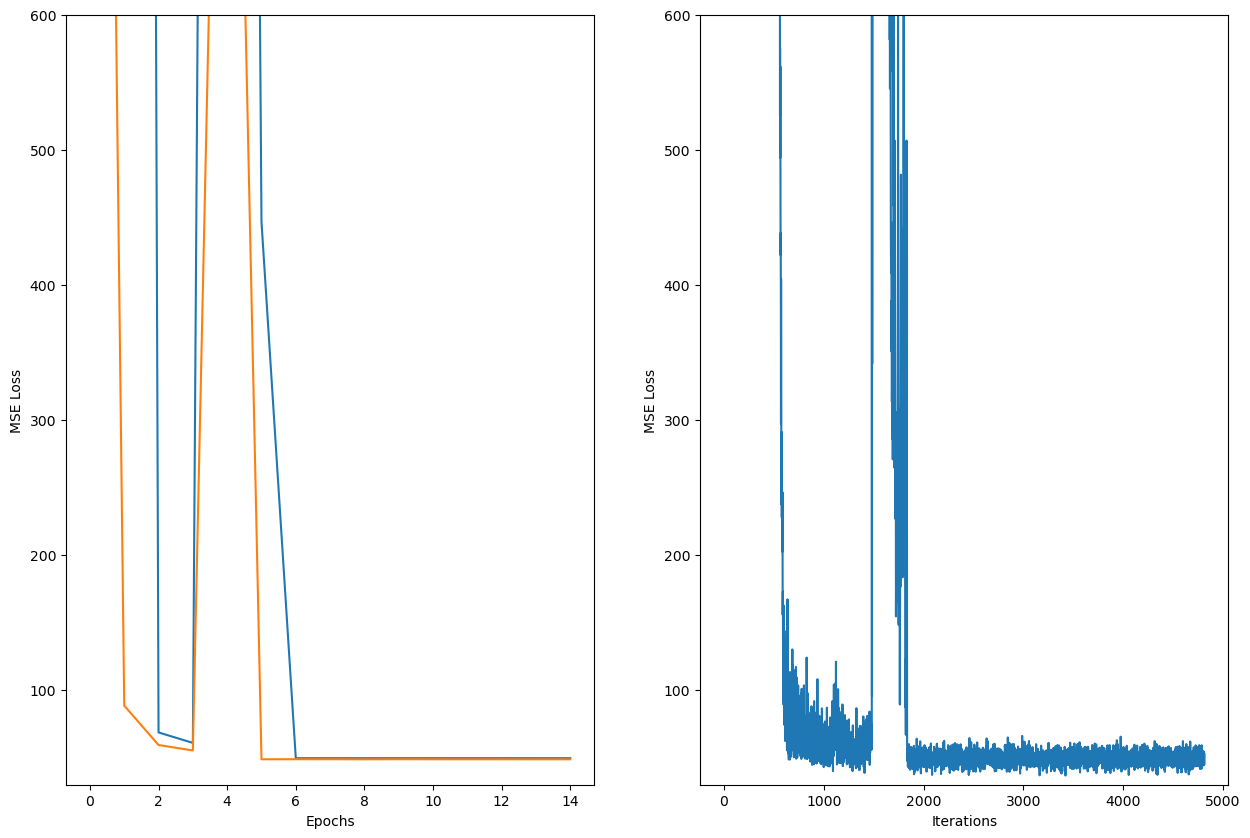

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
axes[0].plot(range(N_epochs), losses, label='Train Loss')
axes[0].plot(range(N_epochs), validate_losses, label = 'Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")
axes[0].set_ylim(30, 600)

axes[1].plot(range(len(batch_loss_graph)), np.array(batch_loss_graph).squeeze(), label = 'Losses for each iteration')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE Loss")
axes[1].set_ylim(30, 600)

In [69]:
mybestmodel  = NeuralNetwork_deep()
test_batch_loss = []
lossfun = nn.MSELoss()
mybestmodel.load_state_dict(torch.load("current_best_model"))
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    loss = lossfun(prediction_score, y_batch) 
    test_batch_loss.append(loss.detach().numpy())
final_loss = (np.mean(np.array(test_batch_loss)))
print(f"Test MSE loss = {final_loss}")

Test MSE loss = 49.59333419799805
